In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output


In [2]:
def extract_answer(text):
    try:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip().split('"')[1].strip()
    except:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip()
    return text_processed

def correct_paranthesis_split(text):
    try:
        text_processed = text.split('"answer":')[-1].split("\n")[1].split(":")[-1].split('"')[1].strip()
        return text_processed
    except:
        return text
    
def process_df(prompt_response_df, rag_response_df):
    prompt_response_df.loc[:, 'extracted_answer'] = prompt_response_df['llm_answer'].apply(extract_answer)
    rag_response_df.loc[:, 'extracted_answer'] = rag_response_df['llm_answer'].apply(extract_answer)

    prompt_response_df_paranthesis_split = prompt_response_df[prompt_response_df.extracted_answer=="{"]
    if prompt_response_df_paranthesis_split.shape[0] > 0:
        prompt_response_df_paranthesis_split.loc[:, "extracted_answer"] = prompt_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
        prompt_response_df_wo_paranthesis_split = prompt_response_df[prompt_response_df.extracted_answer != "{"]
        prompt_response_df = pd.concat([prompt_response_df_wo_paranthesis_split, prompt_response_df_paranthesis_split])

    rag_response_df_paranthesis_split = rag_response_df[rag_response_df.extracted_answer=="{"]
    if rag_response_df_paranthesis_split.shape[0] > 0:
        rag_response_df_paranthesis_split.loc[:, "extracted_answer"] = rag_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
        rag_response_df_wo_paranthesis_split = rag_response_df[rag_response_df.extracted_answer != "{"]
        rag_response_df = pd.concat([rag_response_df_wo_paranthesis_split, rag_response_df_paranthesis_split])
    return prompt_response_df, rag_response_df

def evaluate(df):
    correct = df[df.correct_answer == df.extracted_answer]
    incorrect = df[df.correct_answer != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac


def bootstrap(prompt_response_df, rag_response_df, niter=1000, nsample=150):
    prompt_correct_frac_list = []
    rag_correct_frac_list = []
    for i in tqdm(range(niter)):
        prompt_response_df_sample = prompt_response_df.sample(n=nsample, random_state=i)
        prompt_correct_frac, prompt_incorrect_frac = evaluate(prompt_response_df_sample)
        rag_response_df_sample = rag_response_df.iloc[prompt_response_df_sample.index]
        rag_correct_frac, rag_incorrect_frac = evaluate(rag_response_df_sample)
        prompt_correct_frac_list.append(prompt_correct_frac)
        rag_correct_frac_list.append(rag_correct_frac)
    return prompt_correct_frac_list, rag_correct_frac_list

def plot_figure(prompt_correct_frac_list, rag_correct_frac_list):
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()
    sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
    sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)

    for artist in ax.lines:
        artist.set_edgecolor("black")
    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    plt.legend(bbox_to_anchor=(0.55, 0.9))
    plt.xlim(0.1,0.9)
    ax.axvline(np.mean(prompt_correct_frac_list), color='black', linestyle='--', lw=2)
    ax.axvline(np.mean(rag_correct_frac_list), color='black', linestyle='--', lw=2)
    sns.despine(top=True, right=True)
    plt.show()
    return fig


In [3]:
'''
Following files can be obtained by running the run_mcq_qa.py script.
Make sure to change the parent path and filenames based on where and how you save the files
'''

data_path ='../data/results'

llama_prompt_path = os.path.join(data_path, 'Llama_2_13b_chat_hf_prompt_based_mcq_from_monarch_and_robokop_response.csv')
llama_kg_rag_path = os.path.join(data_path, 'Llama_2_13b_chat_hf_PubMedBert_entity_recognition_based_node_retrieval_rag_based_mcq_from_monarch_and_robokop_response.csv')

gpt_35_prompt_path = os.path.join(data_path, 'gpt_35_turbo_prompt_based_mcq_from_monarch_and_robokop_response.csv')
gpt_35_kg_rag_path = os.path.join(data_path, 'gpt_35_turbo_PubMedBert_entity_recognition_based_node_retrieval_rag_based_mcq_from_monarch_and_robokop_response.csv')

gpt_4_prompt_path = os.path.join(data_path, 'gpt_4_prompt_based_mcq_from_monarch_and_robokop_response.csv')
gpt_4_kg_rag_path = os.path.join(data_path, 'gpt_4_PubMedBert_entity_recognition_based_node_retrieval_rag_based_mcq_from_monarch_and_robokop_response.csv')



In [4]:
llama_prompt_df = pd.read_csv(llama_prompt_path)
llama_kg_rag_df = pd.read_csv(llama_kg_rag_path)

gpt_35_prompt_df = pd.read_csv(gpt_35_prompt_path)
gpt_35_kg_rag_df = pd.read_csv(gpt_35_kg_rag_path)

gpt_4_prompt_df = pd.read_csv(gpt_4_prompt_path)
gpt_4_kg_rag_df = pd.read_csv(gpt_4_kg_rag_path)


llama_prompt_df, llama_kg_rag_df = process_df(llama_prompt_df, llama_kg_rag_df)
gpt_35_prompt_df, gpt_35_kg_rag_df = process_df(gpt_35_prompt_df, gpt_35_kg_rag_df)
gpt_4_prompt_df, gpt_4_kg_rag_df = process_df(gpt_4_prompt_df, gpt_4_kg_rag_df)

clear_output()


In [5]:
llama_prompt_correct_frac_list, llama_rag_correct_frac_list = bootstrap(llama_prompt_df, llama_kg_rag_df)

gpt_35_prompt_correct_frac_list, gpt_35_rag_correct_frac_list = bootstrap(gpt_35_prompt_df, gpt_35_kg_rag_df)

gpt_4_prompt_correct_frac_list, gpt_4_rag_correct_frac_list = bootstrap(gpt_4_prompt_df, gpt_4_kg_rag_df)


100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1545.39it/s]


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_51967/731637856.py:55: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_51967/731637856.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


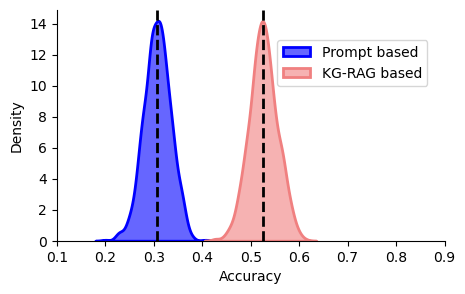

---Prompt based mean and std---
0.30657333333333336
0.027685378411316283

---KG-RAG based mean and std---
0.5257333333333334
0.029079507866842894


In [6]:
llama_fig = plot_figure(llama_prompt_correct_frac_list, llama_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
llama_fig.savefig(os.path.join(fig_path, 'llama_mcq.svg'), format='svg', bbox_inches='tight')      

print('---Prompt based mean and std---')
print(np.mean(llama_prompt_correct_frac_list))
print(np.std(llama_prompt_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(llama_rag_correct_frac_list))
print(np.std(llama_rag_correct_frac_list))


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_51967/731637856.py:55: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_51967/731637856.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


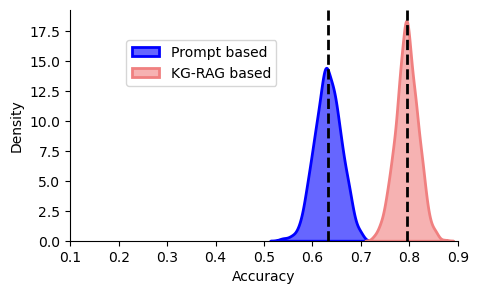

---Prompt based mean and std---
0.6313199999999999
0.027403808332257598

---KG-RAG based mean and std---
0.7942533333333334
0.02310455077829185


In [7]:
gpt_35_fig = plot_figure(gpt_35_prompt_correct_frac_list, gpt_35_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
gpt_35_fig.savefig(os.path.join(fig_path, 'gpt_35_mcq.svg'), format='svg', bbox_inches='tight')      

print('---Prompt based mean and std---')
print(np.mean(gpt_35_prompt_correct_frac_list))
print(np.std(gpt_35_prompt_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(gpt_35_rag_correct_frac_list))
print(np.std(gpt_35_rag_correct_frac_list))


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_51967/731637856.py:55: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_51967/731637856.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


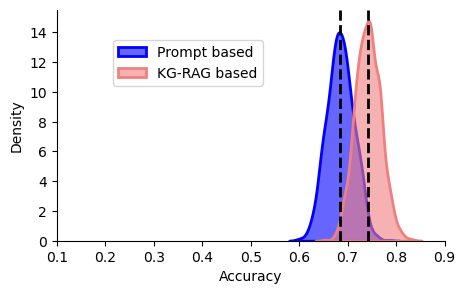

---Prompt based mean and std---
0.6847333333333333
0.027653330118932635

---KG-RAG based mean and std---
0.7417666666666666
0.0259921141887304


In [8]:
gpt_4_fig = plot_figure(gpt_4_prompt_correct_frac_list, gpt_4_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
gpt_4_fig.savefig(os.path.join(fig_path, 'gpt_4_mcq.svg'), format='svg', bbox_inches='tight')      

print('---Prompt based mean and std---')
print(np.mean(gpt_4_prompt_correct_frac_list))
print(np.std(gpt_4_prompt_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(gpt_4_rag_correct_frac_list))
print(np.std(gpt_4_rag_correct_frac_list))
